In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-22 13:38:04.881043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 13:38:05.508980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-22 13:38:05.509062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-22 13:38:05.509070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load the npy files in '/home/hpinkard_waller/data/lung_meld_measurements'

initial_measurements = {}
final_measurements = {}
for file in os.listdir('/home/hpinkard_waller/data/lung_meld_measurements'):
    if file.endswith('.npy'):
        print(file)
        data = np.load('/home/hpinkard_waller/data/lung_meld_measurements/' + file)
        # get the number after 'count' in the filename
        count = int(file.split('count')[1].split('iteration')[0])
        initial = 'iteration_0' in file
        if initial:
            initial_measurements[count] = data
        else:
            final_measurements[count] = data
print(initial_measurements.keys())

lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_0.pt_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_0.pt_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_0.pt_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_30.pt_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_30.pt_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_30.pt_measurements.npy
dict_keys([1000, 400, 200])


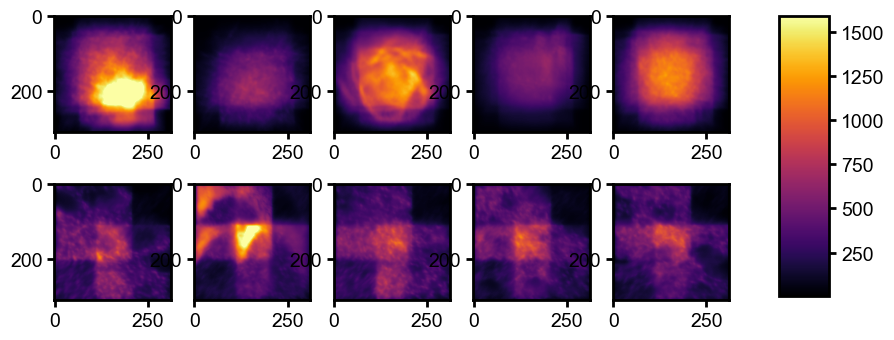

In [3]:
photon_count = 400

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [ ]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

(array([1.3445e+04, 6.4421e+04, 4.7875e+04, 5.8369e+04, 7.9271e+04,
        8.7828e+04, 8.7405e+04, 7.9285e+04, 7.0797e+04, 5.8230e+04,
        4.6731e+04, 3.9901e+04, 2.9602e+04, 2.3166e+04, 1.9985e+04,
        1.7442e+04, 1.6110e+04, 1.4695e+04, 1.2472e+04, 1.1098e+04,
        1.0450e+04, 1.0116e+04, 6.8750e+03, 7.6650e+03, 5.9870e+03,
        5.0870e+03, 4.5610e+03, 4.0960e+03, 3.4730e+03, 3.2620e+03,
        3.1890e+03, 2.5220e+03, 2.5290e+03, 2.7740e+03, 2.8790e+03,
        2.9260e+03, 2.4320e+03, 2.3640e+03, 2.1610e+03, 2.1120e+03,
        1.6600e+03, 1.3720e+03, 1.0850e+03, 8.2900e+02, 7.7500e+02,
        5.8700e+02, 4.4800e+02, 3.1600e+02, 1.4900e+02, 1.3100e+02,
        1.3100e+02, 1.6100e+02, 1.8300e+02, 2.5000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

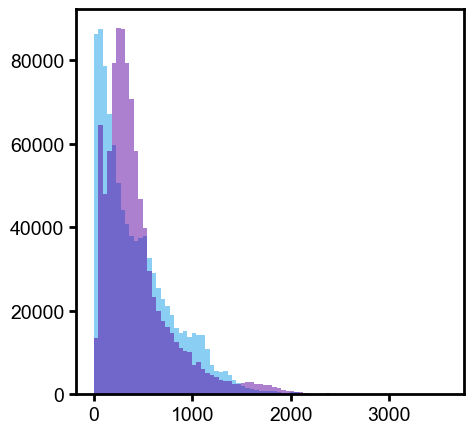

In [27]:

# plot the histograms of the initial and final measurements
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(data_min, data_max, 80)

_ = axs.hist(initial_images[:10].ravel(), bins=bins, alpha=0.5)
_ = axs.hist(final_images[:10].ravel(), bins=bins, alpha=0.5)

# Try cropping to center

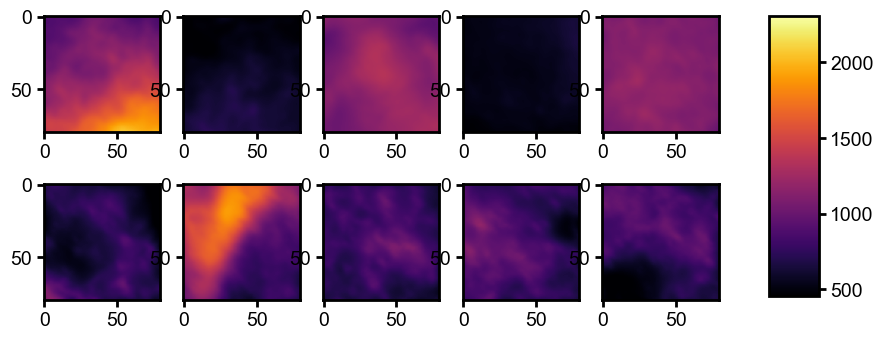

In [4]:
photon_count = 400
crop_size = 80

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

# take center crop_size pixels
initial_images = initial_images[:, initial_images.shape[1] // 2 - crop_size // 2:initial_images.shape[1] // 2 + crop_size // 2, initial_images.shape[2] // 2 - crop_size // 2:initial_images.shape[2] // 2 + crop_size // 2]
final_images = final_images[:, final_images.shape[1] // 2 - crop_size // 2:final_images.shape[1] // 2 + crop_size // 2, final_images.shape[2] // 2 - crop_size // 2:final_images.shape[2] // 2 + crop_size // 2]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [33]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [04:05<00:00, 20.39it/s]


Initial validation NLL: 540.05


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 1: validation NLL: 6.17


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.82it/s]


Epoch 2: validation NLL: 5.99


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.71it/s]


Epoch 3: validation NLL: 5.77


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 4: validation NLL: 5.51


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


Epoch 5: validation NLL: 5.21


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


Epoch 6: validation NLL: 5.11


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 7: validation NLL: 5.12


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 8: validation NLL: 5.12


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 9: validation NLL: 5.05


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


Epoch 10: validation NLL: 5.07


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch 11: validation NLL: 5.01


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Epoch 12: validation NLL: 5.01


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 13: validation NLL: 5.01


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


Epoch 14: validation NLL: 5.01


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 15: validation NLL: 4.98


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Epoch 16: validation NLL: 5.00


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 17: validation NLL: 5.03


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


Epoch 18: validation NLL: 4.98


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 19: validation NLL: 5.03


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


Epoch 20: validation NLL: 4.98


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Epoch 21: validation NLL: 4.98


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 22: validation NLL: 5.04


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


Epoch 23: validation NLL: 5.00


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


Epoch 24: validation NLL: 4.98


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 38.41it/s]


Epoch 25: validation NLL: 4.98


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


Epoch 26: validation NLL: 5.02


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 27: validation NLL: 5.02


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


Epoch 28: validation NLL: 4.99


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 38.71it/s]


Epoch 29: validation NLL: 5.06


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.74it/s]


Epoch 30: validation NLL: 4.98


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Epoch 31: validation NLL: 5.03


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 32: validation NLL: 5.00


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.01it/s]


Epoch 33: validation NLL: 5.02


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 34: validation NLL: 5.03


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Epoch 35: validation NLL: 4.98


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.22it/s]


Epoch 36: validation NLL: 5.08


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 38.88it/s]


Epoch 37: validation NLL: 5.02


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 38: validation NLL: 5.06


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.82it/s]


Epoch 39: validation NLL: 5.01


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 40: validation NLL: 4.99


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 41: validation NLL: 4.99


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 42: validation NLL: 4.99


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 43: validation NLL: 5.05


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 44: validation NLL: 4.98


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 45: validation NLL: 4.98


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


Epoch 46: validation NLL: 5.01


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.94it/s]


Epoch 47: validation NLL: 5.03


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 48: validation NLL: 5.00


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 38.11it/s]


Epoch 49: validation NLL: 4.99


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


Epoch 50: validation NLL: 4.98


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 51: validation NLL: 5.02


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


Epoch 52: validation NLL: 4.98


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 38.46it/s]


Epoch 53: validation NLL: 5.01


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 54: validation NLL: 4.98


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Epoch 55: validation NLL: 5.06


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 37.82it/s]


Epoch 56: validation NLL: 5.02


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 38.36it/s]


Epoch 57: validation NLL: 4.98


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Epoch 58: validation NLL: 4.97


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.00it/s]


Epoch 59: validation NLL: 4.99


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 60: validation NLL: 5.12


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Epoch 61: validation NLL: 4.99


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 62: validation NLL: 4.99


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 39.08it/s]


Epoch 63: validation NLL: 5.02


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 39.07it/s]


Epoch 64: validation NLL: 5.02


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


Epoch 65: validation NLL: 5.01


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 38.34it/s]


Epoch 66: validation NLL: 5.01


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


Epoch 67: validation NLL: 4.99


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


Epoch 68: validation NLL: 4.97


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


Epoch 69: validation NLL: 4.97


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 38.70it/s]


Epoch 70: validation NLL: 5.01


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


Epoch 71: validation NLL: 4.99


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 72: validation NLL: 4.98


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 73: validation NLL: 5.04


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 38.73it/s]


Epoch 74: validation NLL: 5.02


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 75: validation NLL: 5.00


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 37.79it/s]


Epoch 76: validation NLL: 4.98


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]


Epoch 77: validation NLL: 4.99


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 35.05it/s]


Epoch 78: validation NLL: 5.04


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


Epoch 79: validation NLL: 5.10


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


Epoch 80: validation NLL: 5.02


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


Epoch 81: validation NLL: 5.01


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 37.49it/s]


Epoch 82: validation NLL: 4.99


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


Epoch 83: validation NLL: 5.04


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


Epoch 84: validation NLL: 4.99


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 85: validation NLL: 4.98


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


Epoch 86: validation NLL: 5.06


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 87: validation NLL: 4.99


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 39.08it/s]


Epoch 88: validation NLL: 5.00


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 40.05it/s]


Epoch 89: validation NLL: 5.00


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 90: validation NLL: 5.00


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


Epoch 91: validation NLL: 5.01


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Epoch 92: validation NLL: 5.00


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


Epoch 93: validation NLL: 4.99


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 39.39it/s]


Epoch 94: validation NLL: 4.99


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 95: validation NLL: 5.01


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 40.17it/s]


Epoch 96: validation NLL: 4.99


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Epoch 97: validation NLL: 5.01


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


Epoch 98: validation NLL: 4.99
Estimated H(Y|X) = 4.874 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.980 differential entropy/pixel
Estimated I(Y;X) = 0.153 bits/pixel
Initial validation NLL: 567.75


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


Epoch 1: validation NLL: 6.70


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 2: validation NLL: 6.69


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 3: validation NLL: 6.60


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 4: validation NLL: 6.43


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 5: validation NLL: 5.79


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 6: validation NLL: 5.24


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


Epoch 7: validation NLL: 5.16


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


Epoch 8: validation NLL: 5.05


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.33it/s]


Epoch 9: validation NLL: 5.06


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 10: validation NLL: 5.07


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 38.93it/s]


Epoch 11: validation NLL: 5.17


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


Epoch 12: validation NLL: 5.00


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.15it/s]


Epoch 13: validation NLL: 5.03


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


Epoch 14: validation NLL: 5.01


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 38.77it/s]


Epoch 15: validation NLL: 5.10


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Epoch 16: validation NLL: 5.10


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 37.80it/s]


Epoch 17: validation NLL: 5.00


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


Epoch 18: validation NLL: 5.01


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


Epoch 19: validation NLL: 5.03


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


Epoch 20: validation NLL: 5.02


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 33.30it/s]


Epoch 21: validation NLL: 5.01


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 33.24it/s]


Epoch 22: validation NLL: 5.06


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


Epoch 23: validation NLL: 5.01


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 33.11it/s]


Epoch 24: validation NLL: 5.01


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 33.33it/s]


Epoch 25: validation NLL: 5.08


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 33.54it/s]


Epoch 26: validation NLL: 5.01


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


Epoch 27: validation NLL: 5.06


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 33.32it/s]


Epoch 28: validation NLL: 5.20


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 32.74it/s]


Epoch 29: validation NLL: 5.00


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


Epoch 30: validation NLL: 5.02


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


Epoch 31: validation NLL: 4.99


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


Epoch 32: validation NLL: 5.22


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 33.37it/s]


Epoch 33: validation NLL: 5.04


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


Epoch 34: validation NLL: 5.00


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


Epoch 35: validation NLL: 5.00


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 33.53it/s]


Epoch 36: validation NLL: 5.02


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


Epoch 37: validation NLL: 5.02


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 33.80it/s]


Epoch 38: validation NLL: 5.37


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


Epoch 39: validation NLL: 5.02


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 33.53it/s]


Epoch 40: validation NLL: 5.04


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 34.08it/s]


Epoch 41: validation NLL: 5.02


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 33.50it/s]


Epoch 42: validation NLL: 5.00


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


Epoch 43: validation NLL: 5.03


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 32.74it/s]


Epoch 44: validation NLL: 4.98


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


Epoch 45: validation NLL: 4.98


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 33.04it/s]


Epoch 46: validation NLL: 4.99


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 33.57it/s]


Epoch 47: validation NLL: 4.99


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 32.34it/s]


Epoch 48: validation NLL: 4.98


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 32.65it/s]


Epoch 49: validation NLL: 5.00


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


Epoch 50: validation NLL: 5.01


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


Epoch 51: validation NLL: 4.99


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 31.27it/s]


Epoch 52: validation NLL: 4.98


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


Epoch 53: validation NLL: 4.99


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 32.57it/s]


Epoch 54: validation NLL: 5.08


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 32.39it/s]


Epoch 55: validation NLL: 5.02


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 33.12it/s]


Epoch 56: validation NLL: 4.98


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 33.42it/s]


Epoch 57: validation NLL: 5.00


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 32.96it/s]


Epoch 58: validation NLL: 5.13


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


Epoch 59: validation NLL: 5.03


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 33.73it/s]


Epoch 60: validation NLL: 5.00


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


Epoch 61: validation NLL: 5.01


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 33.26it/s]


Epoch 62: validation NLL: 5.05


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 33.34it/s]


Epoch 63: validation NLL: 5.05


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 33.54it/s]


Epoch 64: validation NLL: 5.04


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 33.50it/s]


Epoch 65: validation NLL: 5.02


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 33.30it/s]


Epoch 66: validation NLL: 5.04


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


Epoch 67: validation NLL: 5.01


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


Epoch 68: validation NLL: 4.99


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 33.30it/s]


Epoch 69: validation NLL: 5.00


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 33.12it/s]


Epoch 70: validation NLL: 5.00


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


Epoch 71: validation NLL: 5.00


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


Epoch 72: validation NLL: 5.01


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 32.83it/s]


Epoch 73: validation NLL: 5.02


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


Epoch 74: validation NLL: 5.00


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 33.17it/s]


Epoch 75: validation NLL: 5.02


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 33.52it/s]


Epoch 76: validation NLL: 5.00


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


Epoch 77: validation NLL: 5.01


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


Epoch 78: validation NLL: 4.99


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


Epoch 79: validation NLL: 5.04


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 33.36it/s]


Epoch 80: validation NLL: 4.98


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 33.41it/s]


Epoch 81: validation NLL: 4.99


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 34.21it/s]


Epoch 82: validation NLL: 5.00


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


Epoch 83: validation NLL: 4.98


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 33.48it/s]


Epoch 84: validation NLL: 5.02


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 33.33it/s]


Epoch 85: validation NLL: 5.00
Estimated H(Y|X) = 4.859 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.985 differential entropy/pixel
Estimated I(Y;X) = 0.181 bits/pixel
Initial MI:  0.15259814
Final MI:  0.18139353


```
Estimated H(Y|X) = 4.859 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.985 differential entropy/pixel
Estimated I(Y;X) = 0.181 bits/pixel
Initial MI:  0.15259814
Final MI:  0.18139353
```

In [34]:
patch_size = 35

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [03:50<00:00, 21.65it/s]


Initial validation NLL: 521.03


Epoch 1: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Epoch 1: validation NLL: 6.60


Epoch 2: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


Epoch 2: validation NLL: 6.50


Epoch 3: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 3: validation NLL: 6.35


Epoch 4: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


Epoch 4: validation NLL: 5.74


Epoch 5: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 5: validation NLL: 5.19


Epoch 6: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


Epoch 6: validation NLL: 5.13


Epoch 7: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Epoch 7: validation NLL: 5.20


Epoch 8: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


Epoch 8: validation NLL: 5.07


Epoch 9: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 9: validation NLL: 5.06


Epoch 10: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Epoch 10: validation NLL: 5.07


Epoch 11: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


Epoch 11: validation NLL: 5.10


Epoch 12: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


Epoch 12: validation NLL: 4.99


Epoch 13: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


Epoch 13: validation NLL: 4.99


Epoch 14: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 14: validation NLL: 5.00


Epoch 15: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Epoch 15: validation NLL: 5.02


Epoch 16: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 16: validation NLL: 5.03


Epoch 17: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


Epoch 17: validation NLL: 4.98


Epoch 18: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Epoch 18: validation NLL: 4.96


Epoch 19: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


Epoch 19: validation NLL: 5.00


Epoch 20: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Epoch 20: validation NLL: 5.06


Epoch 21: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Epoch 21: validation NLL: 4.98


Epoch 22: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


Epoch 22: validation NLL: 4.96


Epoch 23: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Epoch 23: validation NLL: 5.04


Epoch 24: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 24: validation NLL: 4.98


Epoch 25: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Epoch 25: validation NLL: 4.98


Epoch 26: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


Epoch 26: validation NLL: 4.96


Epoch 27: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 27: validation NLL: 5.07


Epoch 28: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 28: validation NLL: 4.97


Epoch 29: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


Epoch 29: validation NLL: 5.06


Epoch 30: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 30: validation NLL: 5.03


Epoch 31: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


Epoch 31: validation NLL: 5.10


Epoch 32: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 32: validation NLL: 5.03


Epoch 33: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


Epoch 33: validation NLL: 5.02


Epoch 34: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


Epoch 34: validation NLL: 4.97


Epoch 35: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


Epoch 35: validation NLL: 4.97


Epoch 36: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


Epoch 36: validation NLL: 4.98


Epoch 37: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


Epoch 37: validation NLL: 5.06


Epoch 38: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 38: validation NLL: 5.11


Epoch 39: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Epoch 39: validation NLL: 5.05


Epoch 40: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


Epoch 40: validation NLL: 5.01


Epoch 41: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 41: validation NLL: 5.04


Epoch 42: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


Epoch 42: validation NLL: 4.97


Epoch 43: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Epoch 43: validation NLL: 5.02


Epoch 44: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Epoch 44: validation NLL: 5.07


Epoch 45: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 45: validation NLL: 5.02


Epoch 46: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


Epoch 46: validation NLL: 5.03


Epoch 47: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 47: validation NLL: 5.01


Epoch 48: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


Epoch 48: validation NLL: 5.02


Epoch 49: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


Epoch 49: validation NLL: 5.10


Epoch 50: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


Epoch 50: validation NLL: 5.10


Epoch 51: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 51: validation NLL: 4.98


Epoch 52: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


Epoch 52: validation NLL: 5.02


Epoch 53: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


Epoch 53: validation NLL: 4.99


Epoch 54: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 54: validation NLL: 4.97


Epoch 55: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 55: validation NLL: 4.98


Epoch 56: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


Epoch 56: validation NLL: 4.99


Epoch 57: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


Epoch 57: validation NLL: 5.01


Epoch 58: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


Epoch 58: validation NLL: 5.02


Epoch 59: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Epoch 59: validation NLL: 4.98


Epoch 60: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 60: validation NLL: 5.10


Epoch 61: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


Epoch 61: validation NLL: 5.06


Epoch 62: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


Epoch 62: validation NLL: 5.00
Estimated H(Y|X) = 4.876 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.994 differential entropy/pixel
Estimated I(Y;X) = 0.170 bits/pixel
Initial validation NLL: 576.43


Epoch 1: 100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 1: validation NLL: 6.34


Epoch 2: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


Epoch 2: validation NLL: 5.90


Epoch 3: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


Epoch 3: validation NLL: 5.32


Epoch 4: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


Epoch 4: validation NLL: 5.17


Epoch 5: 100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


Epoch 5: validation NLL: 5.07


Epoch 6: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


Epoch 6: validation NLL: 5.05


Epoch 7: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Epoch 7: validation NLL: 5.03


Epoch 8: 100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


Epoch 8: validation NLL: 5.05


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Epoch 9: validation NLL: 5.02


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


Epoch 10: validation NLL: 5.02


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


Epoch 11: validation NLL: 5.02


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Epoch 12: validation NLL: 5.01


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 21.78it/s]


Epoch 13: validation NLL: 4.98


Epoch 14: 100%|██████████| 100/100 [00:05<00:00, 19.34it/s]


Epoch 14: validation NLL: 5.01


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Epoch 15: validation NLL: 4.99


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Epoch 16: validation NLL: 5.10


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


Epoch 17: validation NLL: 4.99


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 21.21it/s]


Epoch 18: validation NLL: 4.98


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 18.96it/s]


Epoch 19: validation NLL: 5.02


Epoch 20: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


Epoch 20: validation NLL: 5.02


Epoch 21: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 21: validation NLL: 4.98


Epoch 22: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 22: validation NLL: 4.99


Epoch 23: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 23: validation NLL: 5.02


Epoch 24: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 24: validation NLL: 5.05


Epoch 25: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 25: validation NLL: 4.99


Epoch 26: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


Epoch 26: validation NLL: 5.00


Epoch 27: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 27: validation NLL: 4.98


Epoch 28: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 28: validation NLL: 5.02


Epoch 29: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 29: validation NLL: 4.99


Epoch 30: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 30: validation NLL: 4.99


Epoch 31: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 31: validation NLL: 5.03


Epoch 32: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 32: validation NLL: 5.00


Epoch 33: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Epoch 33: validation NLL: 5.06


Epoch 34: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 34: validation NLL: 4.98


Epoch 35: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 35: validation NLL: 4.98


Epoch 36: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 36: validation NLL: 5.07


Epoch 37: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


Epoch 37: validation NLL: 5.11


Epoch 38: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 38: validation NLL: 5.04


Epoch 39: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


Epoch 39: validation NLL: 5.03


Epoch 40: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


Epoch 40: validation NLL: 5.14


Epoch 41: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 41: validation NLL: 4.97


Epoch 42: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 42: validation NLL: 5.02


Epoch 43: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 43: validation NLL: 5.06


Epoch 44: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Epoch 44: validation NLL: 5.02


Epoch 45: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 45: validation NLL: 4.98


Epoch 46: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 46: validation NLL: 4.98


Epoch 47: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 47: validation NLL: 5.02


Epoch 48: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 48: validation NLL: 5.15


Epoch 49: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 49: validation NLL: 5.03


Epoch 50: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 50: validation NLL: 5.00


Epoch 51: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


Epoch 51: validation NLL: 5.00


Epoch 52: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 52: validation NLL: 4.97


Epoch 53: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 53: validation NLL: 4.97


Epoch 54: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Epoch 54: validation NLL: 5.00


Epoch 55: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 55: validation NLL: 4.98


Epoch 56: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


Epoch 56: validation NLL: 5.06


Epoch 57: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 57: validation NLL: 4.99


Epoch 58: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 58: validation NLL: 4.99


Epoch 59: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 59: validation NLL: 4.98


Epoch 60: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 60: validation NLL: 4.97


Epoch 61: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 61: validation NLL: 4.99


Epoch 62: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


Epoch 62: validation NLL: 5.00


Epoch 63: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 63: validation NLL: 4.97


Epoch 64: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 64: validation NLL: 4.98


Epoch 65: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


Epoch 65: validation NLL: 5.00


Epoch 66: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


Epoch 66: validation NLL: 4.98


Epoch 67: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 67: validation NLL: 5.00


Epoch 68: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


Epoch 68: validation NLL: 5.04


Epoch 69: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 69: validation NLL: 5.01


Epoch 70: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


Epoch 70: validation NLL: 5.02


Epoch 71: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 71: validation NLL: 4.99


Epoch 72: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 72: validation NLL: 5.15


Epoch 73: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 73: validation NLL: 5.01


Epoch 74: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 74: validation NLL: 5.01


Epoch 75: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 75: validation NLL: 4.99


Epoch 76: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 76: validation NLL: 5.00


Epoch 77: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


Epoch 77: validation NLL: 5.01


Epoch 78: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


Epoch 78: validation NLL: 5.07


Epoch 79: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 79: validation NLL: 4.98


Epoch 80: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 80: validation NLL: 5.03


Epoch 81: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 81: validation NLL: 4.98


Epoch 82: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 82: validation NLL: 4.99


Epoch 83: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 83: validation NLL: 4.97


Epoch 84: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 84: validation NLL: 4.99


Epoch 85: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 85: validation NLL: 5.00


Epoch 86: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 86: validation NLL: 4.98


Epoch 87: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 87: validation NLL: 4.99


Epoch 88: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Epoch 88: validation NLL: 4.98


Epoch 89: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 89: validation NLL: 4.97


Epoch 90: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 90: validation NLL: 4.98


Epoch 91: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 91: validation NLL: 5.02


Epoch 92: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


Epoch 92: validation NLL: 4.97


Epoch 93: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


Epoch 93: validation NLL: 4.99


Epoch 94: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


Epoch 94: validation NLL: 5.09


Epoch 95: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Epoch 95: validation NLL: 4.97


Epoch 96: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


Epoch 96: validation NLL: 4.98


Epoch 97: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


Epoch 97: validation NLL: 5.03


Epoch 98: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Epoch 98: validation NLL: 5.00


Epoch 99: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 99: validation NLL: 4.98


Epoch 100: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 100: validation NLL: 5.02


Epoch 101: 100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


Epoch 101: validation NLL: 5.01


Epoch 102: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 102: validation NLL: 4.98


Epoch 103: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


Epoch 103: validation NLL: 4.98


Epoch 104: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 104: validation NLL: 4.99


Epoch 105: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 105: validation NLL: 4.98


Epoch 106: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 106: validation NLL: 4.98


Epoch 107: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Epoch 107: validation NLL: 4.97


Epoch 108: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 108: validation NLL: 4.97


Epoch 109: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 109: validation NLL: 5.02


Epoch 110: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 110: validation NLL: 4.98


Epoch 111: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Epoch 111: validation NLL: 4.97


Epoch 112: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 112: validation NLL: 4.97


Epoch 113: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Epoch 113: validation NLL: 5.00


Epoch 114: 100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Epoch 114: validation NLL: 5.00


Epoch 115: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


Epoch 115: validation NLL: 4.97


Epoch 116: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 116: validation NLL: 4.98


Epoch 117: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 117: validation NLL: 4.98


Epoch 118: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Epoch 118: validation NLL: 4.98


Epoch 119: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 119: validation NLL: 5.02


Epoch 120: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


Epoch 120: validation NLL: 4.97


Epoch 121: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


Epoch 121: validation NLL: 5.01


Epoch 122: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 122: validation NLL: 4.99


Epoch 123: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 123: validation NLL: 4.97


Epoch 124: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Epoch 124: validation NLL: 4.97


Epoch 125: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 125: validation NLL: 5.00


Epoch 126: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 126: validation NLL: 5.00


Epoch 127: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Epoch 127: validation NLL: 4.97


Epoch 128: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 128: validation NLL: 4.98


Epoch 129: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 129: validation NLL: 4.97


Epoch 130: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 130: validation NLL: 4.99


Epoch 131: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


Epoch 131: validation NLL: 5.06


Epoch 132: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Epoch 132: validation NLL: 4.98


Epoch 133: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 133: validation NLL: 4.97


Epoch 134: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 134: validation NLL: 4.98


Epoch 135: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 135: validation NLL: 4.97


Epoch 136: 100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 136: validation NLL: 4.97


Epoch 137: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


Epoch 137: validation NLL: 4.99


Epoch 138: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 138: validation NLL: 4.97


Epoch 139: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


Epoch 139: validation NLL: 4.99


Epoch 140: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


Epoch 140: validation NLL: 4.97


Epoch 141: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 141: validation NLL: 5.00


Epoch 142: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


Epoch 142: validation NLL: 4.98


Epoch 143: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


Epoch 143: validation NLL: 4.97


Epoch 144: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


Epoch 144: validation NLL: 4.99


Epoch 145: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Epoch 145: validation NLL: 4.97


Epoch 146: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 146: validation NLL: 4.97


Epoch 147: 100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


Epoch 147: validation NLL: 4.96


Epoch 148: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 148: validation NLL: 5.05


Epoch 149: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 149: validation NLL: 4.98


Epoch 150: 100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 150: validation NLL: 4.97


Epoch 151: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 151: validation NLL: 4.97


Epoch 152: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Epoch 152: validation NLL: 4.97


Epoch 153: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 153: validation NLL: 4.97


Epoch 154: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 154: validation NLL: 4.97


Epoch 155: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 155: validation NLL: 4.97


Epoch 156: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 156: validation NLL: 4.97


Epoch 157: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 157: validation NLL: 4.99


Epoch 158: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 158: validation NLL: 4.97


Epoch 159: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 159: validation NLL: 4.96


Epoch 160: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Epoch 160: validation NLL: 4.97


Epoch 161: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 161: validation NLL: 5.03


Epoch 162: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


Epoch 162: validation NLL: 4.98


Epoch 163: 100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 163: validation NLL: 4.96


Epoch 164: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 164: validation NLL: 4.97


Epoch 165: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 165: validation NLL: 4.99


Epoch 166: 100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


Epoch 166: validation NLL: 4.97


Epoch 167: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 167: validation NLL: 4.97


Epoch 168: 100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 168: validation NLL: 4.96


Epoch 169: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Epoch 169: validation NLL: 4.97


Epoch 170: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch 170: validation NLL: 4.99


Epoch 171: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


Epoch 171: validation NLL: 4.98


Epoch 172: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Epoch 172: validation NLL: 4.98


Epoch 173: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


Epoch 173: validation NLL: 4.96


Epoch 174: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Epoch 174: validation NLL: 4.96


Epoch 175: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch 175: validation NLL: 4.97


Epoch 176: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Epoch 176: validation NLL: 4.98


Epoch 177: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Epoch 177: validation NLL: 4.97


Epoch 178: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


Epoch 178: validation NLL: 4.96


Epoch 179: 100%|██████████| 100/100 [00:04<00:00, 20.32it/s]


Epoch 179: validation NLL: 4.97


Epoch 180: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


Epoch 180: validation NLL: 4.97


Epoch 181: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 181: validation NLL: 4.99


Epoch 182: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


Epoch 182: validation NLL: 4.98


Epoch 183: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch 183: validation NLL: 5.01


Epoch 184: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Epoch 184: validation NLL: 4.97


Epoch 185: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


Epoch 185: validation NLL: 4.98


Epoch 186: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Epoch 186: validation NLL: 4.96


Epoch 187: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Epoch 187: validation NLL: 4.97


Epoch 188: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Epoch 188: validation NLL: 4.97


Epoch 189: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Epoch 189: validation NLL: 4.97


Epoch 190: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Epoch 190: validation NLL: 4.97


Epoch 191: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Epoch 191: validation NLL: 4.98


Epoch 192: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Epoch 192: validation NLL: 4.99


Epoch 193: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


Epoch 193: validation NLL: 4.97


Epoch 194: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Epoch 194: validation NLL: 4.97


Epoch 195: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Epoch 195: validation NLL: 4.98


Epoch 196: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch 196: validation NLL: 4.97


Epoch 197: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 197: validation NLL: 4.97


Epoch 198: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Epoch 198: validation NLL: 4.96


Epoch 199: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Epoch 199: validation NLL: 4.96


Epoch 200: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Epoch 200: validation NLL: 4.97
Estimated H(Y|X) = 4.866 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.961 differential entropy/pixel
Estimated I(Y;X) = 0.138 bits/pixel
Initial MI:  0.17027383
Final MI:  0.13785097


```

Initial MI:  0.17027383
Final MI:  0.13785097
```

In [5]:
# repeat initial

patch_size = 35
initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
initial_noisy_patches = add_noise(initial_patches)
initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
print('Initial MI: ', initial_mi)


100%|██████████| 5000/5000 [00:51<00:00, 97.72it/s] 
2024-01-22 13:39:23.843370: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 532.78


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 1: validation NLL: 6.20


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Epoch 2: validation NLL: 6.10


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


Epoch 3: validation NLL: 5.63


Epoch 4: 100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


Epoch 4: validation NLL: 5.24


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 20.29it/s]


Epoch 5: validation NLL: 5.23


Epoch 6: 100%|██████████| 100/100 [00:04<00:00, 20.35it/s]


Epoch 6: validation NLL: 5.11


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


Epoch 7: validation NLL: 5.11


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 20.12it/s]


Epoch 8: validation NLL: 5.01


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 20.79it/s]


Epoch 9: validation NLL: 4.99


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 10: validation NLL: 5.05


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


Epoch 11: validation NLL: 5.00


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 21.72it/s]


Epoch 12: validation NLL: 5.05


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 21.25it/s]


Epoch 13: validation NLL: 4.99


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 21.03it/s]


Epoch 14: validation NLL: 5.04


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


Epoch 15: validation NLL: 4.98


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


Epoch 16: validation NLL: 5.03


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 21.04it/s]


Epoch 17: validation NLL: 5.00


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


Epoch 18: validation NLL: 4.99


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


Epoch 19: validation NLL: 4.99


Epoch 20: 100%|██████████| 100/100 [00:05<00:00, 16.92it/s]


Epoch 20: validation NLL: 4.96


Epoch 21: 100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


Epoch 21: validation NLL: 5.05


Epoch 22: 100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


Epoch 22: validation NLL: 4.99


Epoch 23: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


Epoch 23: validation NLL: 5.00


Epoch 24: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


Epoch 24: validation NLL: 4.97


Epoch 25: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]


Epoch 25: validation NLL: 5.01


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


Epoch 26: validation NLL: 5.04


Epoch 27: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


Epoch 27: validation NLL: 4.97


Epoch 28: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Epoch 28: validation NLL: 4.97


Epoch 29: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


Epoch 29: validation NLL: 4.99


Epoch 30: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


Epoch 30: validation NLL: 4.99


Epoch 31: 100%|██████████| 100/100 [00:05<00:00, 17.16it/s]


Epoch 31: validation NLL: 4.96


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


Epoch 32: validation NLL: 5.00


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


Epoch 33: validation NLL: 5.02


Epoch 34: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


Epoch 34: validation NLL: 5.02


Epoch 35: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


Epoch 35: validation NLL: 4.98


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 23.59it/s]


Epoch 36: validation NLL: 5.00


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 22.61it/s]


Epoch 37: validation NLL: 4.98


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 22.97it/s]


Epoch 38: validation NLL: 4.99


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


Epoch 39: validation NLL: 4.99


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


Epoch 40: validation NLL: 5.04


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 20.42it/s]


Epoch 41: validation NLL: 5.05


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Epoch 42: validation NLL: 4.99


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 20.15it/s]


Epoch 43: validation NLL: 4.97


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 20.32it/s]


Epoch 44: validation NLL: 4.98


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 20.50it/s]


Epoch 45: validation NLL: 5.03


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 46: validation NLL: 4.96


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 47: validation NLL: 5.03


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Epoch 48: validation NLL: 4.96


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 49: validation NLL: 5.01


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


Epoch 50: validation NLL: 5.00


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 20.52it/s]


Epoch 51: validation NLL: 4.99


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 20.45it/s]


Epoch 52: validation NLL: 4.99


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


Epoch 53: validation NLL: 5.00


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 20.34it/s]


Epoch 54: validation NLL: 5.14


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 55: validation NLL: 5.07


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


Epoch 56: validation NLL: 4.96


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Epoch 57: validation NLL: 4.99


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 21.09it/s]


Epoch 58: validation NLL: 4.97


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 20.37it/s]


Epoch 59: validation NLL: 4.96


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 20.15it/s]


Epoch 60: validation NLL: 5.01


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 20.57it/s]


Epoch 61: validation NLL: 4.98


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 20.41it/s]


Epoch 62: validation NLL: 4.98


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


Epoch 63: validation NLL: 4.96


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 20.34it/s]


Epoch 64: validation NLL: 4.96


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


Epoch 65: validation NLL: 5.06


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


Epoch 66: validation NLL: 5.05


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 20.62it/s]


Epoch 67: validation NLL: 4.98


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


Epoch 68: validation NLL: 4.99


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


Epoch 69: validation NLL: 5.01


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


Epoch 70: validation NLL: 5.01


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


Epoch 71: validation NLL: 5.01


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


Epoch 72: validation NLL: 4.96


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Epoch 73: validation NLL: 5.16


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 20.63it/s]


Epoch 74: validation NLL: 4.95


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


Epoch 75: validation NLL: 5.00


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 20.61it/s]


Epoch 76: validation NLL: 5.21


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


Epoch 77: validation NLL: 5.23


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


Epoch 78: validation NLL: 5.00


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Epoch 79: validation NLL: 5.00


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Epoch 80: validation NLL: 4.98


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


Epoch 81: validation NLL: 4.98


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


Epoch 82: validation NLL: 5.04


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


Epoch 83: validation NLL: 5.01


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 20.72it/s]


Epoch 84: validation NLL: 5.00


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 20.63it/s]


Epoch 85: validation NLL: 5.06


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 20.66it/s]


Epoch 86: validation NLL: 4.98


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 22.97it/s]


Epoch 87: validation NLL: 5.00


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 23.22it/s]


Epoch 88: validation NLL: 4.97


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 21.13it/s]


Epoch 89: validation NLL: 4.97


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 22.49it/s]


Epoch 90: validation NLL: 4.97


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 21.34it/s]


Epoch 91: validation NLL: 4.97


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


Epoch 92: validation NLL: 4.97


Epoch 93: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Epoch 93: validation NLL: 5.00


Epoch 94: 100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


Epoch 94: validation NLL: 4.97


Epoch 95: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


Epoch 95: validation NLL: 4.99


Epoch 96: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 96: validation NLL: 4.99


Epoch 97: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


Epoch 97: validation NLL: 4.99


Epoch 98: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Epoch 98: validation NLL: 4.97


Epoch 99: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Epoch 99: validation NLL: 5.01


Epoch 100: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


Epoch 100: validation NLL: 4.97


Epoch 101: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 101: validation NLL: 4.98


Epoch 102: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


Epoch 102: validation NLL: 4.96


Epoch 103: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Epoch 103: validation NLL: 5.01


Epoch 104: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


Epoch 104: validation NLL: 4.98


Epoch 105: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 105: validation NLL: 4.96


Epoch 106: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


Epoch 106: validation NLL: 4.98


Epoch 107: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Epoch 107: validation NLL: 4.96


Epoch 108: 100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


Epoch 108: validation NLL: 4.98


Epoch 109: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Epoch 109: validation NLL: 4.98


Epoch 110: 100%|██████████| 100/100 [00:05<00:00, 17.21it/s]


Epoch 110: validation NLL: 4.97


Epoch 111: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


Epoch 111: validation NLL: 4.96


Epoch 112: 100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


Epoch 112: validation NLL: 4.96


Epoch 113: 100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


Epoch 113: validation NLL: 5.00


Epoch 114: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 114: validation NLL: 4.99
Estimated H(Y|X) = 4.875 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.959 differential entropy/pixel
Estimated I(Y;X) = 0.121 bits/pixel
Initial MI:  0.12108748


: 

```
Initial MI:  0.12108748
```